In [1]:
from utils.FloorplanToBlenderLib import *
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
from IPython.display import display

img_path = "Images/test5.jpg"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, contour_img = detect.detectOuterContours(gray, blank_image, color=(255, 0, 0))

gray_wall_filter = detect.wall_filter(gray)

gray_wall_filter = ~gray_wall_filter

rooms, colored_rooms = detect.find_rooms(gray_wall_filter.copy())

gray_rooms =  cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes_rooms, room_img = detect.detectPreciseBoxes(gray_rooms, gray_rooms)


# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)
# wall_img = cv2.cvtColor(wall_img, cv2.COLOR_GRAY2BGR)
# detect walls
# boxes_walls, img = detect.detectPreciseBoxes(wall_img)



# display(Image.fromarray(contour_img))
# display(Image.fromarray(colored_rooms))
# display(Image.fromarray(wall_img))

# print(type(contour_img))
print(type(colored_rooms))
print(type(wall_img))

# print(contour_img.shape)
print(colored_rooms.shape)
print(wall_img.shape)





<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(768, 1024, 3)
(768, 1024)


### combine gray detect_room & detect_wall

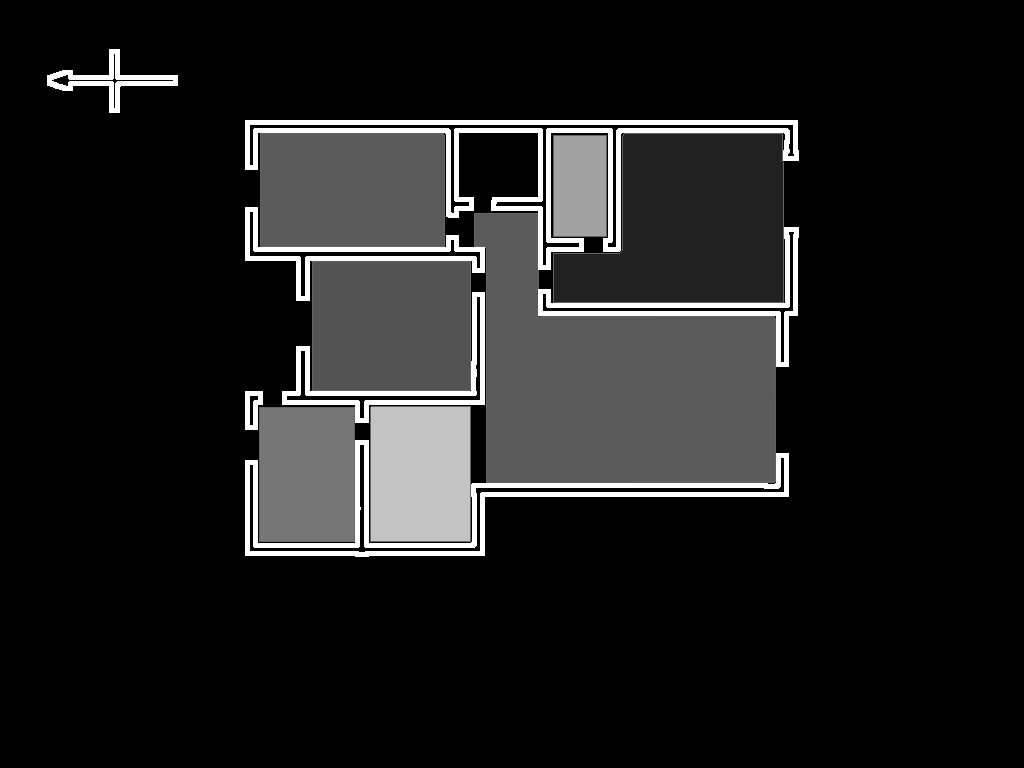

In [2]:
# combine1 = cv2.addWeighted(room_img, 1, wall_img, 1, 0)
# display(Image.fromarray(combine1))

combine2 = cv2.bitwise_or(wall_img, room_img)
display(Image.fromarray(combine2))

### DNN Model

In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
torch.cuda.is_available()

import torch.nn.functional as F
import cv2 
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict,           discrete_cmap
discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

# Create tensor for pytorch
# img = cv2.imread(img_path)
parts_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
parts_img = 2 * (parts_img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
parts_img = np.moveaxis(parts_img, -1, 0)

# Convert to pytorch, enable cuda
parts_img = torch.tensor([parts_img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([parts_img.shape[2],parts_img.shape[3]])%2

    height = parts_img.shape[2] - size_check[0]
    width = parts_img.shape[3] - size_check[1]

    parts_img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(parts_img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


heatmaps, rooms, icons = split_prediction(prediction, parts_img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']

        



D:\Documents\Akademic\Programming\Bootcamp\iSpan_BigData\99_Project\3_專題執行\contour_detection\Detection_testing_v0\utils\plotting.py:611: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)
D:\Documents\Akademic\Programming\Bootcamp\iSpan_BigData\99_Project\3_專題執行\contour_detection\Detection_testing_v0\utils\post_prosessing.py:334: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pol in polygon_union:


In [7]:
polygons_to_image?

Signature:
polygons_to_image(
    polygons,
    types,
    room_polygons,
    room_types,
    height,
    width,
)
Docstring: <no docstring>
File:      d:\documents\akademic\programming\bootcamp\ispan_bigdata\99_project\3_專題執行\contour_detection\detection_testing_v0\utils\plotting.py
Type:      function


### Try to solve plot -> image

In [16]:
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
print(pol_icon_seg.shape)
print(type(pol_icon_seg))
display(Image.fromarray(pol_icon_seg))


# combine3 = cv2.bitwise_or(combine2, pol_icon_seg)
# display(Image.fromarray(combine3))


# plt.figure(figsize=(12,12))
# ax = plt.subplot(1, 1, 1)
# ax.axis('off')
# iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
# plt.show()

(768, 1024)
<class 'numpy.ndarray'>


ValueError: Could not save to PNG for display

<PIL.Image.Image image mode=F size=1024x768 at 0x20FD1B5ABB0>

### Try

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [18]:
plt.gcf?

Signature: plt.gcf()
Docstring:
Get the current figure.

If there is currently no figure on the pyplot figure stack, a new one is
created using `~.pyplot.figure()`.  (To test whether there is currently a
figure on the pyplot figure stack, check whether `~.pyplot.get_fignums()`
is empty.)
File:      c:\users\chihh\appdata\roaming\python\python39\site-packages\matplotlib\pyplot.py
Type:      function


Figure(432x288)
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=432x288 at 0x20F5982C3A0>
(288, 432, 4)


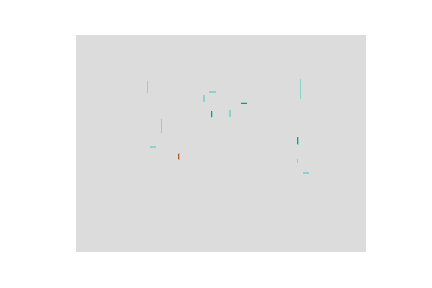

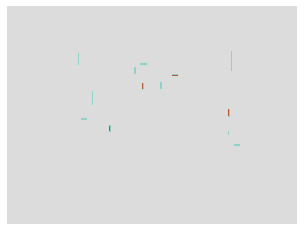

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
fig = plt.gcf()
print(fig)
new_img = fig2img(fig)
print(new_img)
new_img_nparr = np.array(new_img)
# new_img_nparr.resize(768, 1024, 3)

print(new_img_nparr.shape)
display(Image.fromarray(new_img_nparr))

In [17]:
combine3 = cv2.bitwise_or(combine2, new_img_nparr)
display(Image.fromarray(combine3))

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [ ]:
from PIL import Image, ImageDraw, ImageFilter
# 產生遮罩影像
maskImg = Image.new("L", (720, 480))

# 繪製遮罩區域
maskDraw = ImageDraw.Draw(maskImg)
maskDraw.ellipse((50, 50, 470, 430), fill=255)

# 模糊化
maskImg = maskImg.filter(ImageFilter.GaussianBlur(30))

# 顯示遮罩影像
maskImg.show()